In [185]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import h5py # 加载 .h5型数据文件

#### 加载图片数据集

In [186]:
def load_dataset():
    # 训练集有 209 张 64x64像素（宽x高）的图像，包含三个色素（R，G，B）
    train_dataset = h5py.File('datasets/train_catvnoncat.h5', "r")
    train_x_orig = np.array(train_dataset["train_set_x"][:]) # features
    train_y_orig = np.array(train_dataset["train_set_y"][:]) # labels( 0: not cat, 1: is cat)
    
    # 测试集有 50 张 64x64像素（宽x高）的图像，包含三个色素（R，G，B）
    test_dataset = h5py.File('datasets/test_catvnoncat.h5', "r")
    test_x_orig = np.array(test_dataset["test_set_x"][:]) # features
    test_y_orig = np.array(test_dataset["test_set_y"][:]) # labels
    
    # 存储的是以 bytes类型 保存的两个类别名称字符串：[b’non-cat’，b’cat’]
    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    # 类别转换为二阶张量
    train_y_orig = train_y_orig.reshape((1, train_y_orig.shape[0]))
    test_y_orig = test_y_orig.reshape((1, test_y_orig.shape[0]))
    
    return train_x_orig, train_y_orig, test_x_orig, test_y_orig, classes

In [187]:
train_x_orig , train_y , test_x_orig , test_y , classes = load_dataset()

In [188]:
print(train_x_orig.shape)
print(train_y.shape)

print(test_x_orig.shape)
print(test_y.shape)

(209, 64, 64, 3)
(1, 209)
(50, 64, 64, 3)
(1, 50)


In [189]:
test_y

array([[1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0,
        0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0,
        0, 0, 1, 1, 1, 0]], dtype=int64)

In [190]:
classes

array([b'non-cat', b'cat'], dtype='|S7')

#### 对数据集的分析

**查看**训练集的第26张图片及其对应类别

y=1, it's a cat picture
(64, 64, 3)


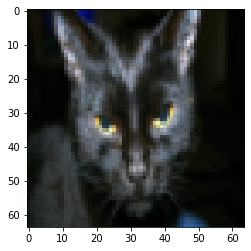

In [191]:
index = 25
# docode：bytes to str
print("y=" + str(train_y[0][index]) + ", it's a " + classes[np.squeeze(train_y[:,index])].decode("utf-8") + " picture")
print(train_x_orig[index].shape)

plt.imshow(train_x_orig[index])

**笔记**

**squeeze 函数**：从数组的形状中删除**所有的**单维度条目，即把shape中为1的维度去掉，数组的shape会变化

In [192]:
a = np.arange(10).reshape(1,1,1,10)
np.squeeze(a).shape

(10,)

In [193]:
print(train_y[:,index])
print(np.squeeze(train_y[:,index]))

print(train_y[:,index].shape)
print(np.squeeze(train_y[:,index]).shape)

[1]
1
(1,)
()


**笔记**

使用squeeze函数的目的是为了能够解码，**数组的shape会变化**

In [194]:
print(classes[train_y[:,index]])
print(classes[np.squeeze(train_y[:,index])])

[b'cat']
b'cat'


#### 数据的预处理

为了方便后续的神经网络训练，对每张图片进行**降维操作**，最后转置：  
（64，64，3, num）-->（64 x 64 x 3, num）=（12288，num）

In [195]:
train_x_flatten  = train_x_orig.reshape(train_x_orig.shape[0], -1).T
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

print ("训练集降维最后的维度： " + str(train_x_flatten.shape))
print ("测试集降维之后的维度: " + str(test_x_flatten.shape))

训练集降维最后的维度： (12288, 209)
测试集降维之后的维度: (12288, 50)


像素值的取值范围是0到255（红绿蓝三色素的取值都是这个范围），常见的**预处理**是居中和标准化，但对于图片数据集，归一化即可，即除以255让数据位于[0,1]之间。  
不进行归一化的话，后面sigmoid计算可能会出现**数值溢出问题**

In [196]:
train_x_orig.max(), train_x_orig.min(), test_x_orig.max(), test_x_orig.min()

(255, 0, 255, 0)

In [197]:
train_x = train_x_flatten / 255
test_x = test_x_flatten / 255

#### 构建模型--针对批量样本
建立浅层神经网络（Logistic回归）的主要步骤是：
- 1.定义模型结构（例如输入特征的数量）
- 2.初始化模型的参数
- 3.循环：
 - 3.1 计算当前损失（正向传播）
 - 3.2 计算当前梯度（反向传播）
 - 3.3 更新参数（梯度下降）
 
##### 构建 sigmoid() 函数

In [198]:
def sigmoid(z):
    """z  - 标量或任何size（包括张量）的numpy数组 
    """
    return 1 / (1 + np.exp(-z))

测试 sigmoid() 函数

In [199]:
#print("====================测试sigmoid====================")
#print ("sigmoid(0) = " + str(sigmoid(0)))      # 应该等于 0.5
#print ("sigmoid(9.2) = " + str(sigmoid(9.2)))  # 应该是逼近 1

In [200]:
# 处理张量
sig_test = np.random.randn(2, 3)
print(sigmoid(sig_test))

[[0.57163907 0.14504307 0.28622384]
 [0.6876108  0.32941441 0.43695623]]


##### 初始化参数 w 和 b
浅层神经网络（没有隐藏层），只有一个神经元：
- 权重用的是 $w$，而不是 $W$
- 把 $w$ 全部初始化为 $0$ 也没问题，效果仍等同于随机初始化，因为不存在不同神经元之间功能相同的问题

In [201]:
def initialize_with_zeros(dim):
    """
        零初始化
        参数：dim  - w矢量（列向量）的大小（参数数量，特征数，等于X的行数，前面转置过）
    """
    w = np.zeros(shape = (dim, 1))
    b = 0
    
    assert(w.shape == (dim, 1))                        # 确保 w 的维度是(dim,1)
    assert(isinstance(b, float) or isinstance(b, int)) # 确保 b 的类型是float或者int
    
    return (w , b)

##### 计算当前参数的成本函数 $J$ 及梯度 $dw、db$
表面上看起来参数的梯度计算没有用到成本，实际上是有的

In [202]:
def propagate(w, b, X, y):
    """
    实现批量样本的前向传播，成本函数（loss）的计算，以及反向传播的梯度计算。
    参数：
        X  - 矩阵类型为（64 * 64 * 3，num）
        y  - 真正的“标签”矢量（行向量）
    """
    m = X.shape[1]
    
    #正向传播：计算激活值矢量 a （即为预测概率 y_hat，是行向量），np.dot 是矩阵乘法
    a = sigmoid(np.dot(w.T, X) + b) 
    
    # 计算损失（逻辑回归的负对数似然成本），* 是哈达玛积（element-wise product）
    cost = (- 1 / m) * np.sum(y * np.log(a) + (1 - y) * (np.log(1 - a)))
    # squeeze之前的shape是 (1,)
    cost = np.squeeze(cost)
    
    # 反向传播：多写一步 dz
    dz = a - y
    dw = (1 / m) * np.dot(X, dz.T)                  
    db = (1 / m) * np.sum(dz)                        
    
    # 确保: dw与w 形状相同，db、cost 是标量
    assert(dw.shape == w.shape)
    assert(db.shape == ())
    assert(db.dtype == float)   
    assert(cost.shape == ()) 
    
    # 保存 dw和db
    grads = {"dw": dw, "db": db}
    
    return (grads , cost)

测试成本函数和梯度的计算

In [203]:
#print("====================测试propagate====================")\

# 初始化一些参数，2个特征
#w, b, X, y = np.array([[1], [2]]), 2, np.array([[1,2], [3,4]]), np.array([[1, 0]])
#grads, cost = propagate(w, b, X, y)
#print ("dw = ", grads["dw"])
#print ("db = ", grads["db"])
#print ("cost = " + str(cost))

##### 梯度下降法来迭代更新参数
目标是通过最小化成本函数 J 来学习 w 和 b。对于参数 $\theta$，更新规则是 $\theta = \theta - \alpha* \text{ } d\theta$，其中 $\alpha$ 是学习率。

In [204]:
def optimize(w, b, X, y, num_iterations, learning_rate, print_cost=500):
    """
    梯度下降算法来多次迭代优化w和b，每迭代50次记录一下损失值，用于后面绘制成本曲线   
    
    参数：
        print_cost  - 是否每500步迭代打印一次损失值    
    """   
    costs = []
    
    for i in range(1, num_iterations+1):
        # 计算当前参数下的成本和梯度
        grads, cost = propagate(w, b, X, y)                
        
        # 梯度下降法更新参数，是减号
        dw = grads["dw"]
        db = grads["db"]
        w = w - learning_rate * dw
        b = b - learning_rate * db
        
        # 每迭代 50 次记录一下损失值
        if i % 50 == 0:
            costs.append(cost)
            
        # 每梯度下降500次，打印一下损失值
        if print_cost and (i % print_cost == 0):
            print("迭代的次数: %i ， 损失： %f" % (i, cost))
        
    params  = {"w" : w, "b" : b }
    grads = {"dw": dw, "db": db } 
    
    return (params , grads , costs)

测试一下优化函数

In [205]:
print("====================测试optimize====================")
# 初始化参数
#w, b, X, y = np.array([[1], [2]]), 2, np.array([[1,2], [3,4]]), np.array([[1, 0]])
#params, grads, costs = optimize(w, b, X, y, num_iterations=3000, learning_rate=0.01, print_cost=True)
# print ("w = " + str(params["w"]))
# print ("b = " + str(params["b"]))
# print ("dw = " + str(grads["dw"]))
# print ("db = " + str(grads["db"]))

====================测试optimize====================


##### 类别的预测--批量
预测有两个步骤：
- 1.计算 $\hat{y} = a = \sigma(w^T X + b)$ 
- 2.输出预测类别，a的值为0（如果激活值<= 0.5）或者 1（如果激活值> 0.5）

In [206]:
def predict(w, b, X):
    """
    使用学习后的逻辑回归参数（w，b）来预测类别（预测概率转换为预测类别，0或1）
    
    返回：
        矢量 y_class_prediction  - 预测类别【0 | 1】
    
    """       
    # 样本数
    m = X.shape[1]
    
    # 计算每个图片有猫出现的预测概率，正向传播
    a = sigmoid(np.dot(w.T , X) + b)
    # y_hat = a
    
    # 将每个样本的预测概率转换为预测类别
    y_class_prediction = np.zeros((1, m))
    for i in range(m):
        y_class_prediction[0, i] = 1 if a[0, i] > 0.5 else 0
    
    assert(y_class_prediction.shape == (1, m))
    
    return y_class_prediction

In [207]:
# 但是也可以直接修改自身数值
a = np.array([[0.9, 0.2]])
for i in range(a.shape[1]):
    a[0, i] = 1 if a[0, i] > 0.5 else 0
print(a)

[[1. 0.]]


再测试一下

In [208]:
#print("====================测试predict====================")
#w, b, X, y = np.array([[1], [2]]), 2, np.array([[1,2], [3,4]]), np.array([[1, 0]])
#print("predictions = " + str(predict(w, b, X)))

##### 模型构建

In [209]:
def model(X_train, y_train, X_test, y_test, num_iterations=2000, learning_rate=0.5, print_cost=500):
    """
    通过调用之前定义的函数来构建传统的逻辑回归模型
    
    参数：
        print_cost  - 设置为true，每500次迭代打印一次成本
    
    返回：
        d  - 包含有关模型信息的字典。
    """
    # 初始化参数，输入特征维度
    w, b = initialize_with_zeros(X_train.shape[0])
    
    # 多次迭代，更新参数，计算成本
    parameters, grads, costs = optimize(w, b, X_train, y_train, num_iterations, learning_rate, print_cost)
    w, b = parameters["w"], parameters["b"]
    
    # 批量预测训练集和测试集数据
    y_class_prediction_test = predict(w, b, X_test)
    y_class_prediction_train = predict(w, b, X_train)
    
    # 预测准确性计算， 两种写法，np.abs取绝对值（为了对 1 求和，代表类别不一致）
    print("训练集准确率：" , np.mean(y_class_prediction_train == y_train) )
    print("测试集准确率：" , format(1 - np.mean(np.abs(y_class_prediction_test - y_test))) )
    
    d = {
            "costs": costs,
            "Y_prediction_test": y_class_prediction_test,
            "Y_prediciton_train": y_class_prediction_train,
            "w": w,
            "b": b,
            "learning_rate": learning_rate,
            "num_iterations": num_iterations 
    }
    return d

In [210]:
np.abs(np.array([[1,0]]) - np.array([1,1]))

array([[0, 1]])

正式的测试，使用真实数据；根据预测准确率可知，**存在过拟合问题**

In [211]:
#print("====================测试model====================")     
d = model(train_x, train_y, test_x, test_y, learning_rate=0.005, print_cost=100)

迭代的次数: 100 ， 损失： 0.644898
迭代的次数: 200 ， 损失： 0.484894
迭代的次数: 300 ， 损失： 0.377761
迭代的次数: 400 ， 损失： 0.331775
迭代的次数: 500 ， 损失： 0.303529
迭代的次数: 600 ， 损失： 0.280094
迭代的次数: 700 ， 损失： 0.260226
迭代的次数: 800 ， 损失： 0.243100
迭代的次数: 900 ， 损失： 0.228144
迭代的次数: 1000 ， 损失： 0.214944
迭代的次数: 1100 ， 损失： 0.203189
迭代的次数: 1200 ， 损失： 0.192644
迭代的次数: 1300 ， 损失： 0.183124
迭代的次数: 1400 ， 损失： 0.174481
迭代的次数: 1500 ， 损失： 0.166597
迭代的次数: 1600 ， 损失： 0.159374
迭代的次数: 1700 ， 损失： 0.152731
迭代的次数: 1800 ， 损失： 0.146601
迭代的次数: 1900 ， 损失： 0.140927
迭代的次数: 2000 ， 损失： 0.135659
训练集准确率： 0.9904306220095693
测试集准确率： 0.7


##### 绘制成本变化图

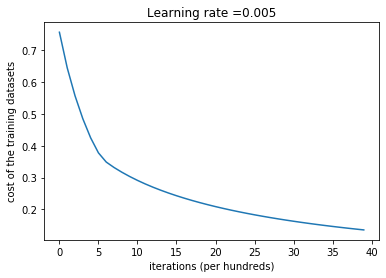

In [212]:
plt.figure(figsize=(6,4))
plt.plot(d['costs'])
plt.ylabel('cost of the training datasets')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()

##### 不同学习率的尝试
调整学习率至关重要，学习率 $\alpha$ 决定了参数更新的速度。如果学习率过高，可能会“超过”最优值；如果过低则将需要过多次迭代才能收敛到最佳值
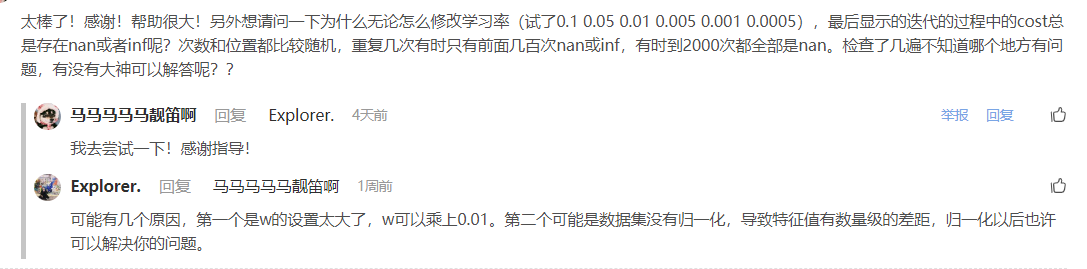

learning rate is: 0.01
迭代的次数: 500 ， 损失： 0.460014
迭代的次数: 1000 ， 损失： 0.116557
迭代的次数: 1500 ， 损失： 0.087496
训练集准确率： 0.9952153110047847
测试集准确率： 0.6799999999999999

-------------------------------------------------------

learning rate is: 0.001
迭代的次数: 500 ， 损失： 0.488058
迭代的次数: 1000 ， 损失： 0.418276
迭代的次数: 1500 ， 损失： 0.370553
训练集准确率： 0.8899521531100478
测试集准确率： 0.64

-------------------------------------------------------

learning rate is: 0.0001
迭代的次数: 500 ， 损失： 0.616087
迭代的次数: 1000 ， 损失： 0.591382
迭代的次数: 1500 ， 损失： 0.572081
训练集准确率： 0.6842105263157895
测试集准确率： 0.36

-------------------------------------------------------



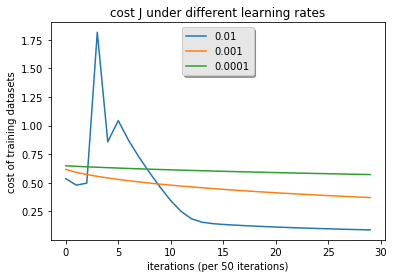

In [213]:
# 0.01的学习率过大，刚开始cost甚至会急剧增加
learning_rates = [0.01, 0.001, 0.0001]
models = {} 
for i in learning_rates:
    print ("learning rate is: " + str(i))
    models[i] = model(train_x, train_y, test_x, test_y, num_iterations=1500, learning_rate=i)
    print ('\n' + "-------------------------------------------------------" + '\n')

for i in learning_rates:
    plt.plot(models[i]["costs"], label= str(models[i]["learning_rate"]))

plt.title("cost J under different learning rates")
plt.ylabel('cost of training datasets')
plt.xlabel('iterations (per 50 iterations)')
legend = plt.legend(loc='upper center', shadow=True)

# ？？
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()

#### 由学习率引出的问题
当学习率较大时，比如0.05，z会太小或太大，在sigmoid（z）里面，就会溢出，会警告：
- RuntimeWarning: divide by zero encountered in log cost = (- 1 / m) * np.sum(Y * np.log(A) + (1 - Y) * (np.log(1 - A))) 
- RuntimeWarning: invalid value encountered in multiply cost = (- 1 / m) * np.sum(Y * np.log(A) + (1 - Y) * (np.log(1 - A))) 

**应从学习率和激活函数两方面分析**

In [214]:
d = model(train_x, train_y, test_x, test_y, learning_rate=0.05, print_cost=100)

d:\softwares\anaconda\envs\tf\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  
d:\softwares\anaconda\envs\tf\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in multiply
  


迭代的次数: 100 ， 损失： 13.037828
迭代的次数: 200 ， 损失： 3.156698
迭代的次数: 300 ， 损失： 0.377705
迭代的次数: 400 ， 损失： 3.410418
迭代的次数: 500 ， 损失： 0.100939
迭代的次数: 600 ， 损失： 0.064794
迭代的次数: 700 ， 损失： 0.023730
迭代的次数: 800 ， 损失： 0.016533
迭代的次数: 900 ， 损失： 0.013259
迭代的次数: 1000 ， 损失： 0.011326
迭代的次数: 1100 ， 损失： 0.010017
迭代的次数: 1200 ， 损失： 0.009052
迭代的次数: 1300 ， 损失： 0.008301
迭代的次数: 1400 ， 损失： 0.007695
迭代的次数: 1500 ， 损失： 0.007191
迭代的次数: 1600 ， 损失： 0.006765
迭代的次数: 1700 ， 损失： 0.006398
迭代的次数: 1800 ， 损失： 0.006078
迭代的次数: 1900 ， 损失： 0.005795
迭代的次数: 2000 ， 损失： 0.005544
训练集准确率： 1.0
测试集准确率： 0.6799999999999999


**刚开始的损失都超过10了 ！！！**

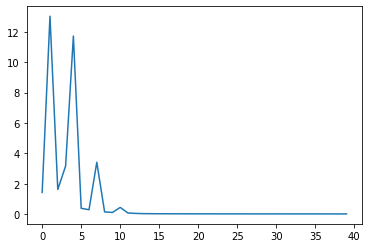

In [215]:
plt.plot(d['costs'])

**为何训练集的预测准确率如此之高 ？？**

In [216]:
d = model(train_x, train_y, test_x, test_y, learning_rate=0.1, print_cost=100)

d:\softwares\anaconda\envs\tf\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  
d:\softwares\anaconda\envs\tf\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in multiply
  


迭代的次数: 100 ， 损失： nan
迭代的次数: 200 ， 损失： nan
迭代的次数: 300 ， 损失： nan
迭代的次数: 400 ， 损失： nan
迭代的次数: 500 ， 损失： 19.261492
迭代的次数: 600 ， 损失： nan
迭代的次数: 700 ， 损失： nan
迭代的次数: 800 ， 损失： nan
迭代的次数: 900 ， 损失： nan
迭代的次数: 1000 ， 损失： nan
迭代的次数: 1100 ， 损失： nan
迭代的次数: 1200 ， 损失： nan
迭代的次数: 1300 ， 损失： nan
迭代的次数: 1400 ， 损失： nan
迭代的次数: 1500 ， 损失： nan
迭代的次数: 1600 ， 损失： nan
迭代的次数: 1700 ， 损失： nan
迭代的次数: 1800 ， 损失： nan
迭代的次数: 1900 ， 损失： nan
迭代的次数: 2000 ， 损失： nan
训练集准确率： 1.0
测试集准确率： 0.6799999999999999


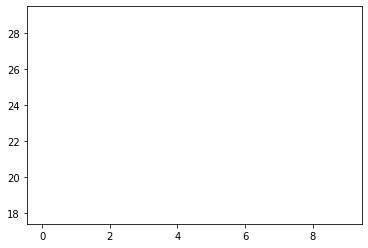

In [217]:
plt.plot(d['costs'])